Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Kamil Matejuk"

---

# Bayesowskie Sieci Neuronowe (ang. *Bayesian Neural Networks*)

BSN (Bayesowskie Sieci Neuronowe) są rozszerzeniem tradycyjnych sieci neuronowych o elementy wnioskowania i uczenia Bayesowskiego. Wśród zalet tych sieci możemy wskazać:
- możliwość pomiaru niepewności modelu (*uncertainty*) dla predykcji (przy różnych poziomach pewności - ang. *confidence levels*)
- istnieje możliwość zakodowanie wiedzy apriori na temat rozkładu wag sieci

## Podejście Bayesowskie

W przypadku zwykłych sieci neuronowych parametry (wagi) sieci estymujemy metodą Maximum Likelihood, która maksymalizuje prawdopodobieństwo obserwowania danych $\mathcal{D}$ pod warunkiem parametrów $\mathbf{w}$:

$$
\text{arg max}_\theta p(\mathcal{D}|\mathbf{w})
$$

Skutkiem tego jest punktowa estymata parametrów, która nie pozwala modelować niepewności. Możemy jednak wykorzystać twierdzenie Bayesa i przekształcić problem do **uczenia rozkładu parametrów modelu**: 

$$
p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
$$

W ten sposób opisujemy rozkład posteriora, gdzie $p(\mathbf{w})$ to wiedza apriori na temat parametrów (wag) modelu. Używając wnioskowania Bayesowskiego, możemy uzyskać predykcje modelu obliczając całkę po całej przestrzeni parametrów $\mathbf{w}$:


$$
p(y | x, \mathcal{D}) = \int p(y | x,\mathbf{w}) p(\mathbf{w} | \mathcal{D})\, d\mathbf{w}
$$

Oczywiście taka całka jest praktycznie nie możliwa do policzenia - z jednej strony mamy nieskończenie wiele możliwych wartości parametrów, a ponadto nie znamy rozkładu danych.

W literaturze zaproponowano kilka możliwych aproksymacji tego problemu:
- jedną z nich jest [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) (2014) **i na niej skupimy się w tym zeszycie**
- Monte Carlo Markov Chain (MCMC)


Alternatywnie zamiast aproksymować rozkład predykcyjny możemy zaproksymować całą Bayesowską sieć neuronową -- np. za pomocą mechanizmu Dropout, w postaci metody Monte Carlo Dropout: [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)

## Variational inference

Na początku chcielibyśmy policzyć rozkład posterior parametrów $p(\mathbf{w}|\mathcal{D})$. Nie znamy tego rozkładu ani nie jesteśmy w stanie policzyć rozkładu danych $p(\mathcal{D})$. Możemy jednak wykorzystać mechanizm Variational Inference. Określamy rozkład wariacyjny (ang. *variational distribution*), który pochodzi z rodziny znanych nam rozkładów (np. rozkład normalny) i powinien aproksymować skomplikowany nieznany nam rozkład. W poniższych wyprowadzeniach będziemy rozważać gausowski rozkład wariacyjny:

$$
q_\theta(\mathbf{w}) \approx p(\mathbf{w} | \mathcal{D})
$$

$\theta$ to parametry rozkładu wariacyjnego. W celu pomiaru jak dobrze rozkład wariacyjny aproksymuje ten pożądany (rzeczywisty) rozkład musimy określić pewną miarę odległości. Wykorzystamy dywergencję Kullbacka-Leiblera. Podczas optymalizacji problemu, będziemy poszukiwać optymalnych (najlepszych) parametrów rozkładu wariacyjnego, które minimalizują dywergencję KL:

$$
\theta_{opt} = \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w}) || p(\mathbf{w}|\mathcal{D}) \right]
$$

Dywergencja Kullbacka-Leiblera jest określona w następujący sposób:

$$
\text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] = \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathcal{D})}\, d\mathbf{w}
$$

Aby policzyć tę całkę musimy znać rozkład posteriora $p(\mathbf{w}|\mathcal{D})$, dlatego stosujemy następujące przekształcenie:


$$
\begin{align}
\theta_{opt} &= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] \\
&= \text{arg min}_\theta \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w})p(\mathcal{D}|\mathbf{w})}\, d\mathbf{w}\\
&= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w}) \right] - {\mathbb{E}}_{q_\theta(\mathbf{w})}\left[log p(\mathcal{D}|\mathbf{w})\right]
\end{align}
$$

Tę wartość nazywamy [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Aby uzyskać nieobciążone estymatory gradientów ELBO możemy zastosować estymację Monte Carlo losując wagi modelu $N$-krotnie i sumując wyniki kilku takich losowań. Podsumowując, optymalne wagi znajdujemy w następujący sposób:

$$\tag{1}
\theta_{opt} = \text{arg min}_\theta \frac{1}{N}\sum^N_{i=1} \log q_\theta(\mathbf{w}^{(i)}) - \log p(\mathbf{w}^{(i)}) - \log p(\mathcal{D}|\mathbf{w}^{(i)})
$$

gdzie $\mathbf{w}^{(i)}$ jest próbkowane z rozkładu $q_\theta(\mathbf{w})$. Zauważ, że ostatni człon $\log p(\mathcal{D}|\mathbf{w}^{(i)})$ to funkcja likelihood zwykłej sieci neuronowej.

## Sztuczka z reparametryzacją (ang. *reparametrization trick*)

Kolejnym problemem jest związanym z powyższą metodą jest brak możliwości obliczania pochodnych (brak różniczkowalności) w procesie optymalizacji parametrów sieci. Rozwiązaniem jest wykorzystanie sztuczki z reparametryzację (więcej szczegółów znajdziesz w [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557)). Zakładając, że chcemy wykorzystywać rozkład normalny, każdy wyuczalny parametr (waga) sieci $\theta$ będzie określony przez dwa inne parametry - średnią  $\mu$ oraz wariancję  $\sigma^2$ rozkładu normalnego:

$$
\theta = (\mu, \sigma^2)
$$

Używając sztuczki z reparametryzacją otrzymujemy:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

gdzie $\epsilon$ jest losowany z rozkładu normalnego standardowego:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Jednym nieróżniczkowalnym członem jest $\epsilon$, jednak zależy nam głównie na parametrach $\mu$ oraz $\sigma$. Możemy policzyć gradienty w następujący sposób (w rzeczywistości biblioteki do uczenia sieci neuronowych obliczają te pochodne za nas):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

Parametry są aktualizowane w następujący sposób:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

Tak zdefiniowane uczenie jest nazywane _Bayes by Backprop_ i jest kluczowym elementem Bayesowskich Sieci Neuronowych.

In [2]:
import torch
import torch.nn as nn
import math
import pandas as pd

# Prior

Poniższa implementacja bayesowskich sieci neuronowych jest oparta na pracy `https://arxiv.org/pdf/1505.05424.pdf`. Najpierw zaimplementujmy prior dla wag sieci. Wykorzystana będzie tutaj mikstura dwóch rozkładów normalnych. Implementacja ta jest zgodna z opisem w punkcie `3.3. Scale mixture prior` w przytoczonej publikacji.

In [3]:
class NGaussianMixturePrior:
    
    def __init__(
        self, 
        sigmas: list[float], 
        mixings: list[float],
    ):
        self.mixings = mixings
        
        self.w_priors = [torch.distributions.Normal(0, s) for s in sigmas]
        self.b_priors = [torch.distributions.Normal(0, s) for s in sigmas]
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_priors = [wp.log_prob(weights).exp() for wp in self.w_priors]
        w_prior = sum(m * wp for m, wp in zip(self.mixings, w_log_priors))
        
        b_log_priors = [bp.log_prob(weights).exp() for bp in self.b_priors]
        b_prior = sum(m * bp for m, bp in zip(self.mixings, b_log_priors))
        
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        w_log_prob = w_prior.log().mean()
        b_log_prob = b_prior.log().mean()
        log_prob = torch.Tensor(0)
        if not w_log_prob.isinf(): log_prob += w_log_prob
        if not b_log_prob.isinf(): log_prob += b_log_prob
        return log_prob

# Zadanie 1 (2 pkt) - Liniowa warstwa Bayesowska
Uzupełnij poniższą implementację bayesowskiej warstwy liniowej. Pamiętaj, że w omówionym podejściu wykorzystujemy rozkład normalny, a każda waga sieci jest określona przez parametry: $\mu$ oraz $\sigma^2$. 

- w funkcji `__init__()` zadeklaruj i zainicjuj wyuczalne parametry rozkładów normalnych, osobno dla wag sieci (`weight`) oraz obciążeń (`biases`)
- w funkcji `forward()` wylosuj wagi oraz obciążenia z przygotowanych rozkładów; użyj sztuczki z reparametryzacją; pamiętaj, że wariancja/odchylenie standardowe nie może być ujemne (zobacz rozdział: `3.2. Gaussian variational posterior` w podanej publikacji)
- w funkcji `variational_log_prob()` oblicz logarytm prawdopodobieństwa wariacyjnego $\log q_\phi(\theta^{(i)} | \mathcal{D}) $

In [4]:
class BayesianLinear(nn.Module):
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    
    def __init__(self, num_input_features: int, num_output_features: int, prior: NGaussianMixturePrior):
        """Implement initialization of weights and biases values"""
        super().__init__()
        
        self.prior = prior
        
        self.last_weights_ = None
        self.last_biases_ = None
        
        # Define weights parameters and initialize them using uniform distribution
        self.weight_mu = nn.Parameter(torch.empty(num_input_features, num_output_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.empty(num_input_features, num_output_features).uniform_(-5, -4))
        
        # Define biases parameters and initialize them using uniform distribution
        self.bias_mu = nn.Parameter(torch.empty(num_output_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.empty(num_output_features).uniform_(-5, -4))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)
        
        weights = self.weight_mu + weight_sigma * weight_epsilon
        biases = self.bias_mu + bias_sigma * bias_epsilon
        
        self.last_weights_ = weights
        self.last_biases_ = biases
        
        return x @ weights + biases
        
    def prior_log_prob(self) -> torch.Tensor:
        """Calculates the prior log prob of sampled weights and biases."""
        return self.prior.log_prob(weights=self.last_weights_, biases=self.last_biases_)
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement the variational log prob."""
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        weight_variational_distribution = torch.distributions.Normal(self.weight_mu, weight_sigma)
        bias_variational_distribution = torch.distributions.Normal(self.bias_mu, bias_sigma)
        
        weight_log_prob = weight_variational_distribution.log_prob(self.last_weights_).sum()
        bias_log_prob = bias_variational_distribution.log_prob(self.last_biases_).sum()
        
        return weight_log_prob + bias_log_prob

### Bayesowski Wielowarstwowy Perceptron
Używając powyższej bayesowskiej wartstwy liniowej możemy zaimplementować bayesowską wersję wielowarstwowego perceptrona (ang. *MLP*). 

In [5]:
class BayesianMLP(nn.Module):
    def __init__(
        self, 
        num_input_features: int,
        num_hidden_features: int,
        num_output_classes: int,
        prios_args: dict,
    ):
        super().__init__()
        
        self.layer_1 = BayesianLinear(
            num_input_features, num_hidden_features, 
            prior=NGaussianMixturePrior(**prios_args),
        )
        self.layer_2 = BayesianLinear(
            num_hidden_features, num_output_classes, 
            prior=NGaussianMixturePrior(**prios_args),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.layer_1(x))
        x = self.softmax(self.layer_2(x))
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

# Zadanie 2 (1.5 pkt) - ELBO dla `N` próbek Monte Carlo
Zaimplementuj liczenie ELBO korzystając ze wzoru $(1)$. Zastosuj funkcję kosztu `Negative Log Likelihood (NLL)` i pamiętaj, że w ten sposób człon: $- \log p(\mathcal{D}|\mathbf{w}^{(i)})$ będzie w pełni obliczany przez NLL (jego wartość należy dodać do łącznego kosztu, a nie odejmować!). Dodatkowo należy podkreślić, że log likelihood próbki danych to suma log likelihood'ów każdego z elementów zbioru.

In [6]:
from typing import Union, Tuple


class ELBO(nn.Module):
    def __init__(self, N: int):
        super().__init__()
        
        self.N = N
        self.nll = nn.NLLLoss(reduction="none")
        
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        predictions = []
        log_posteriors = []
        log_priors = []
        total_nll_loss = 0
        targets = torch.argmax(targets, dim=1)
        
        for _ in range(self.N):
            preds = model(inputs)
            predictions.append(preds)
            
            log_variational = model.variational_log_prob()
            log_prior = model.prior_log_prob()
            
            log_posteriors.append(log_variational)
            log_priors.append(log_prior)

            total_nll_loss += self.nll(preds, targets).sum()

        # Compute the mean log prior and log posterior over all samples
        mean_log_prior = torch.stack(log_priors).mean()
        mean_log_posterior = torch.stack(log_posteriors).mean()

        # Compute the ELBO
        loss = mean_log_posterior - mean_log_prior + (total_nll_loss / self.N)
        
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [ ]:
import _08_utils as utils

## Ewaluacja modelu
Wykorzystamy tutaj zbiór MNIST (ręcznie pisanych cyfr) i wykonamy kilka analiz, aby zobaczyć gdzie model był pewien swoich decyzji (zarówno tych poprawnych jak i błędnych) oraz zobaczymy przykłady, gdzie model nie był pewien predykcji.

In [8]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000, limit_test_samples_to=500)

In [22]:
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
    prios_args=dict(sigmas=[1, 1e-6], mixings=[0.5, 0.5])
)

loss_fun = ELBO(N=10)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [23]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epochs: 100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


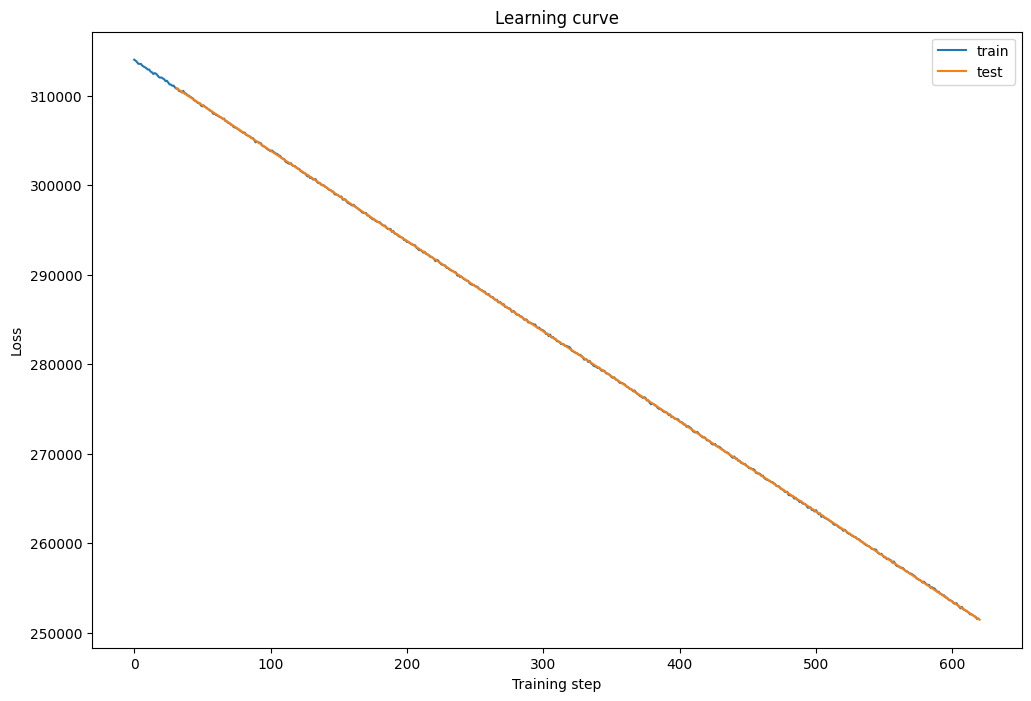

In [24]:
utils.show_learning_curves(dict(train=train_metrics, test=test_metrics))

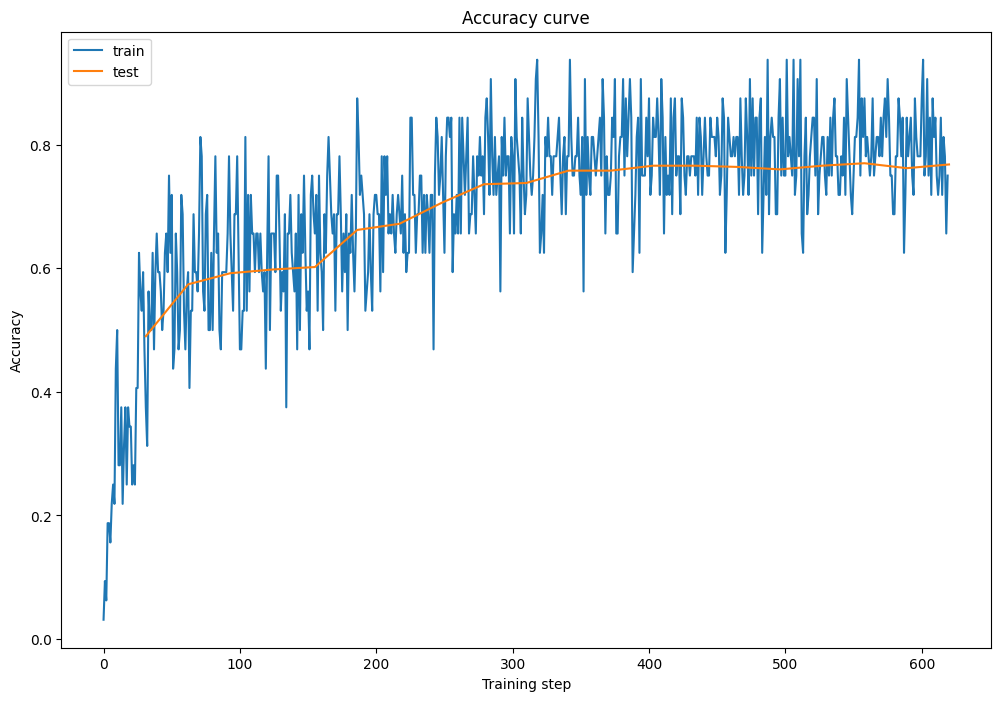

In [12]:
utils.show_accuracy_curves(dict(train=train_metrics, test=test_metrics))

In [13]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 0.9375
Best testing accuracy: 0.7699999809265137


In [14]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


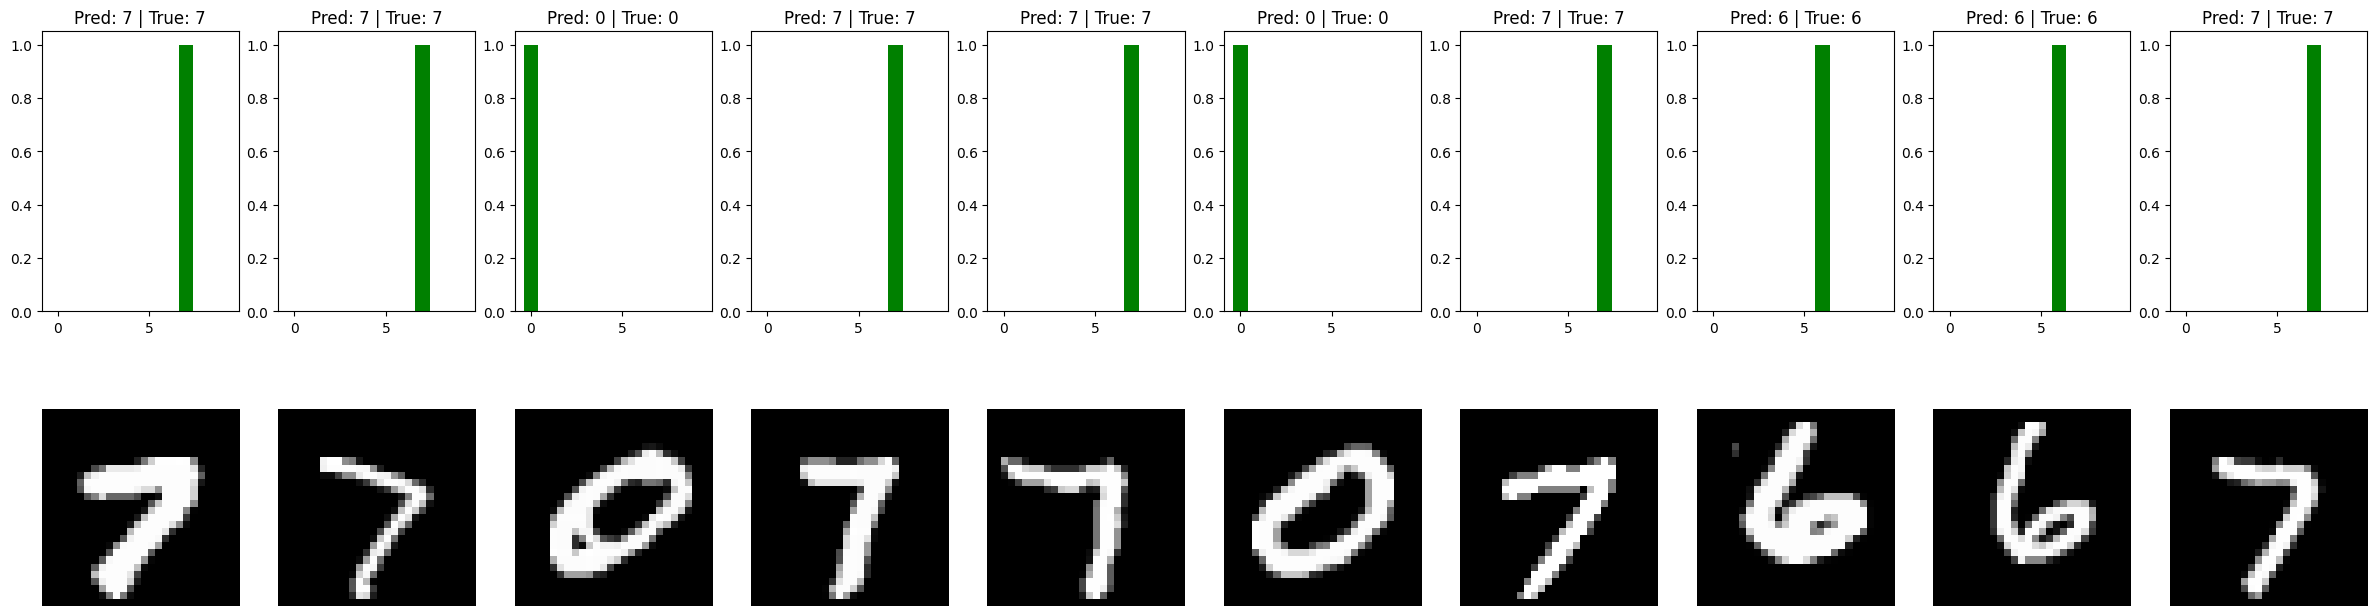

In [15]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


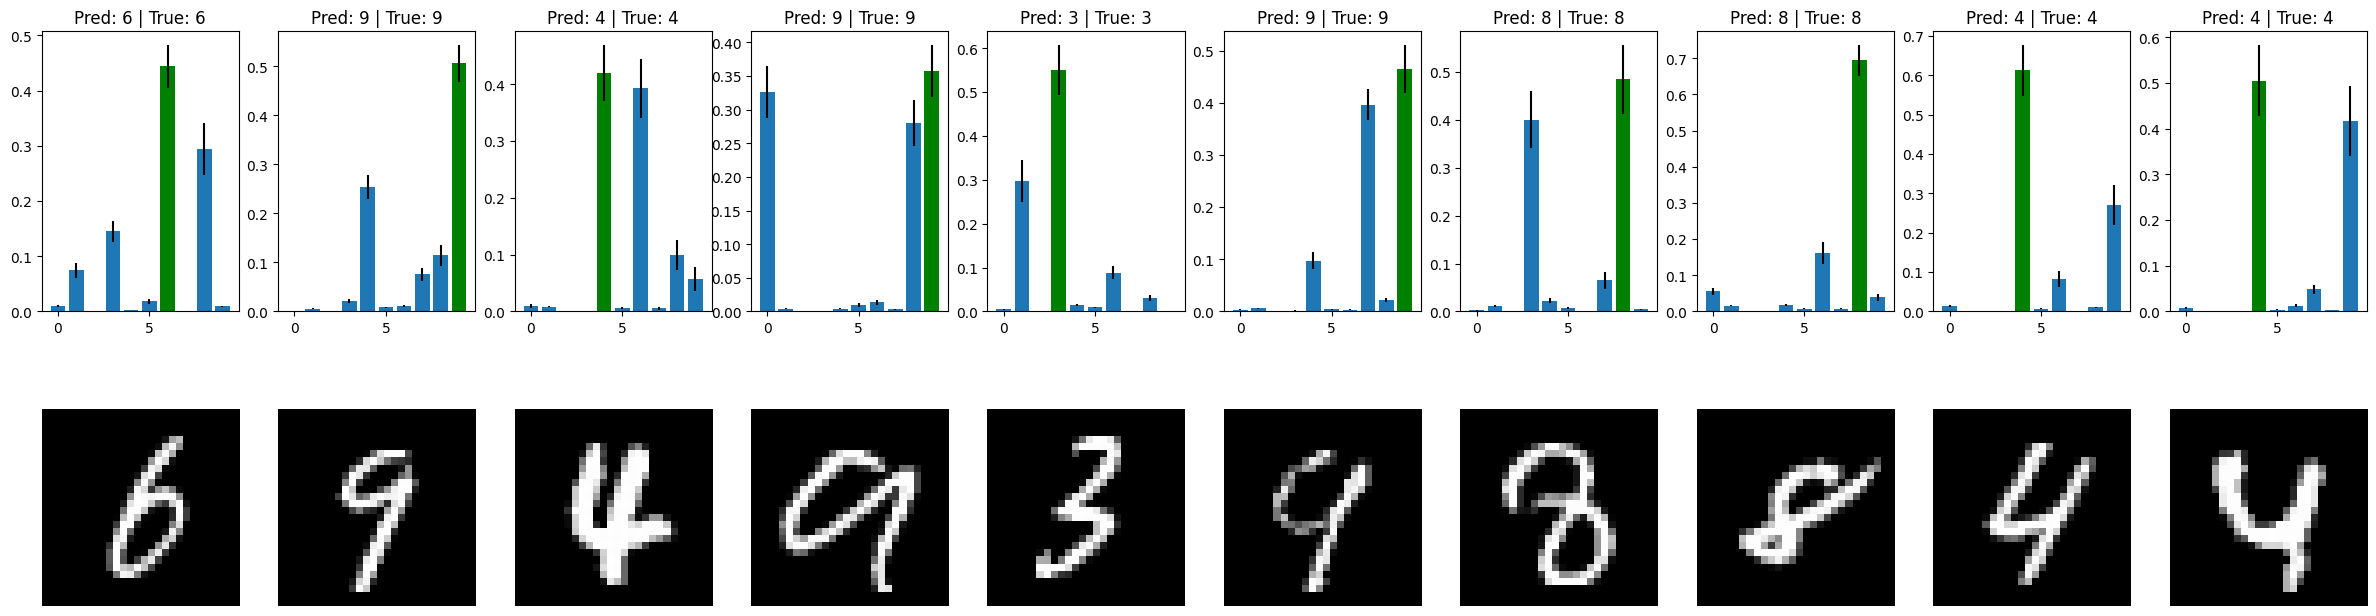

In [16]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


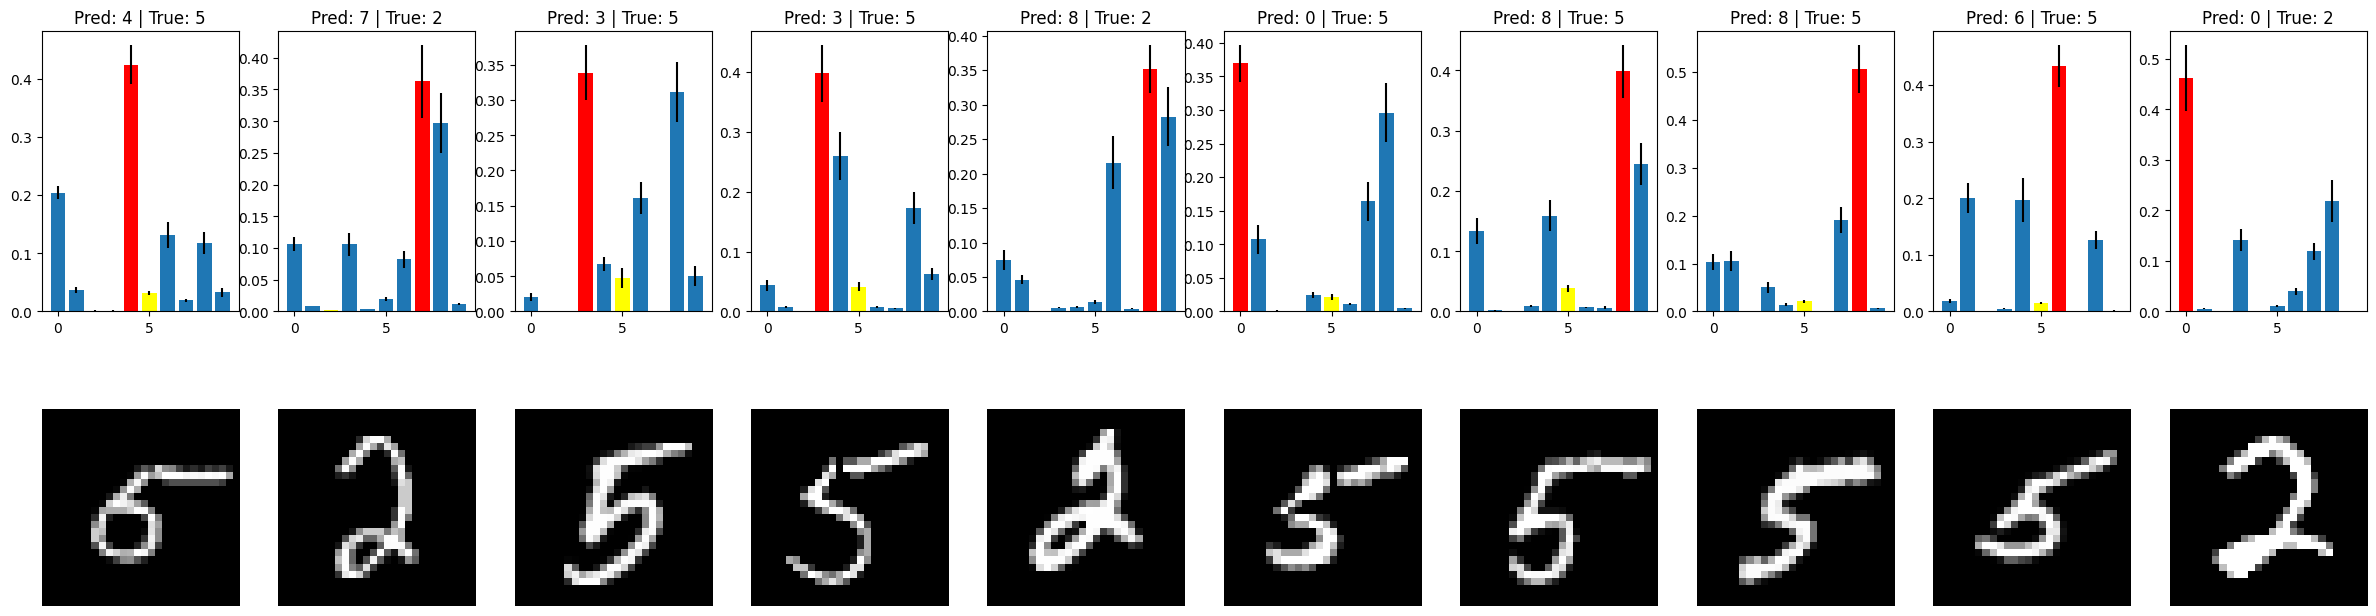

In [17]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


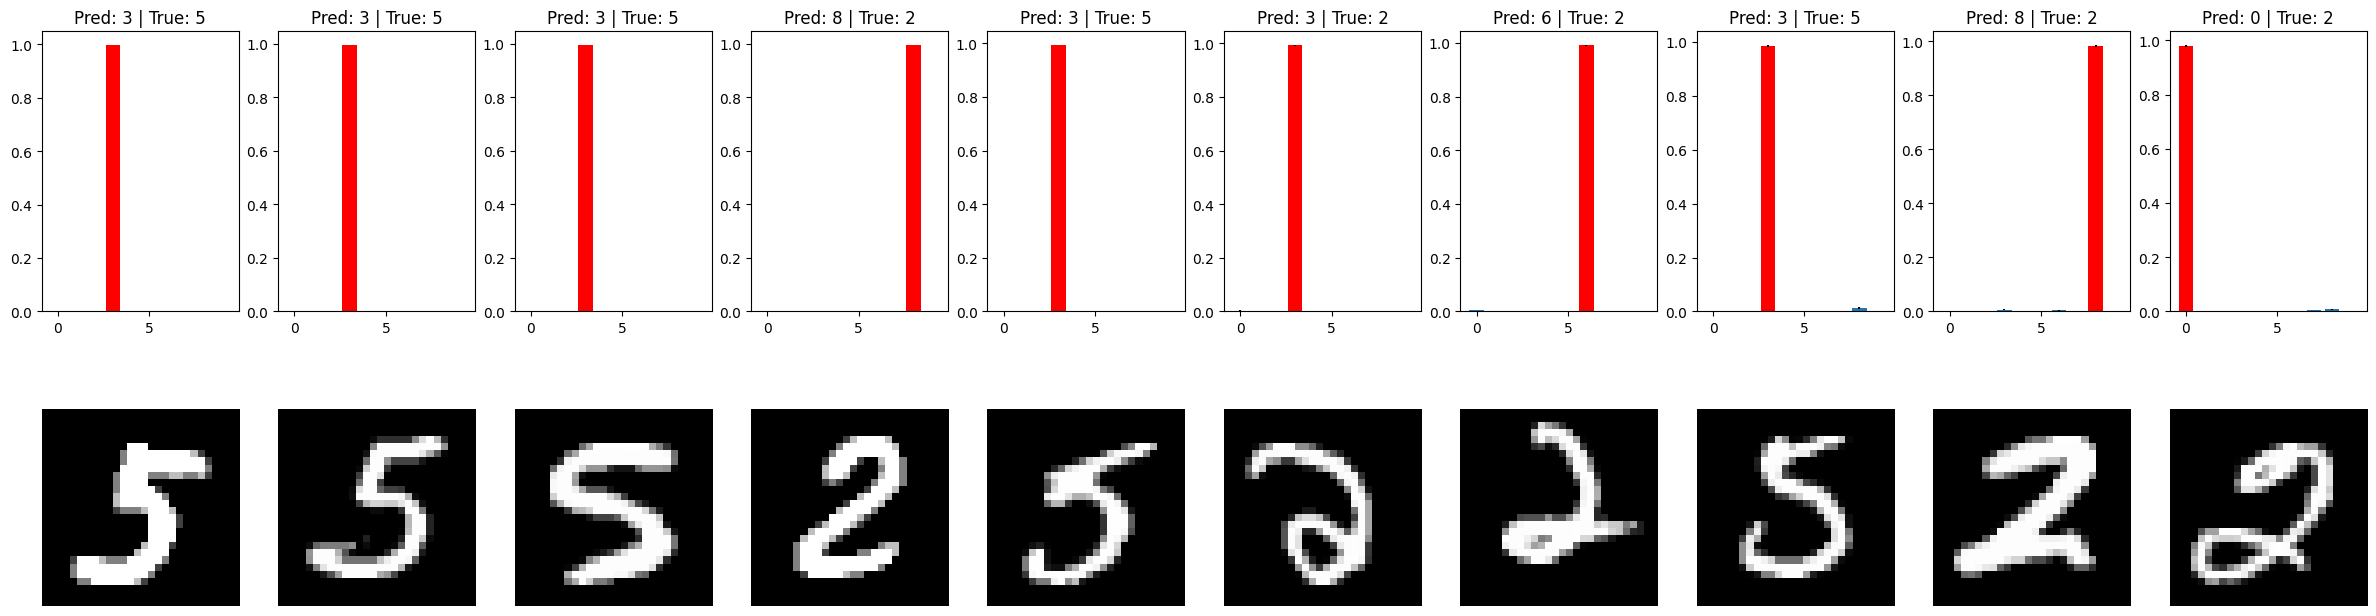

In [18]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

# Zadanie 3 (0.1 pkt)
Przypisz do zmiennych `layer_1_means` oraz `layer_2_means` wartości parametrów średnich rozkładu normalnego $\mu$ dla odpowiednio pierwszej i drugiej warstwy.

Histogram of weights for layer 1


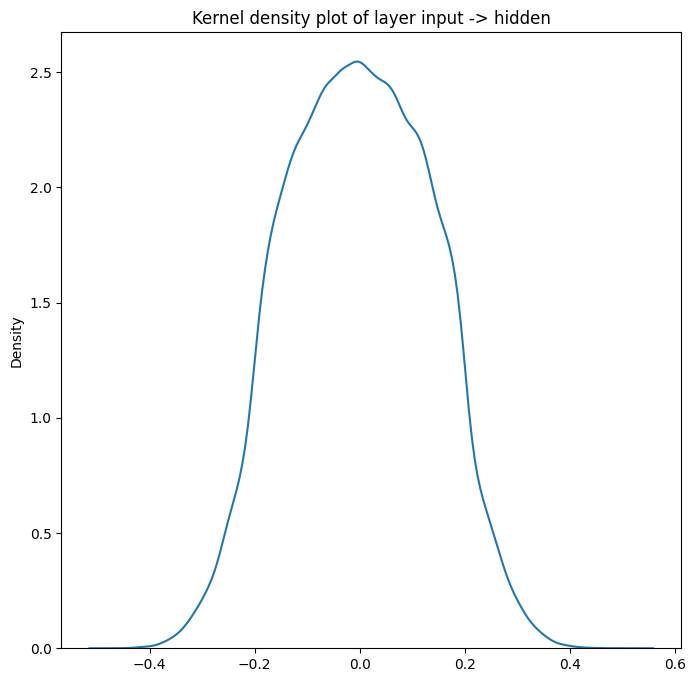

In [19]:
layer_1_means = model.layer_1.weight_mu

utils.visualize_weights(layer_1_means, "layer input -> hidden")
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


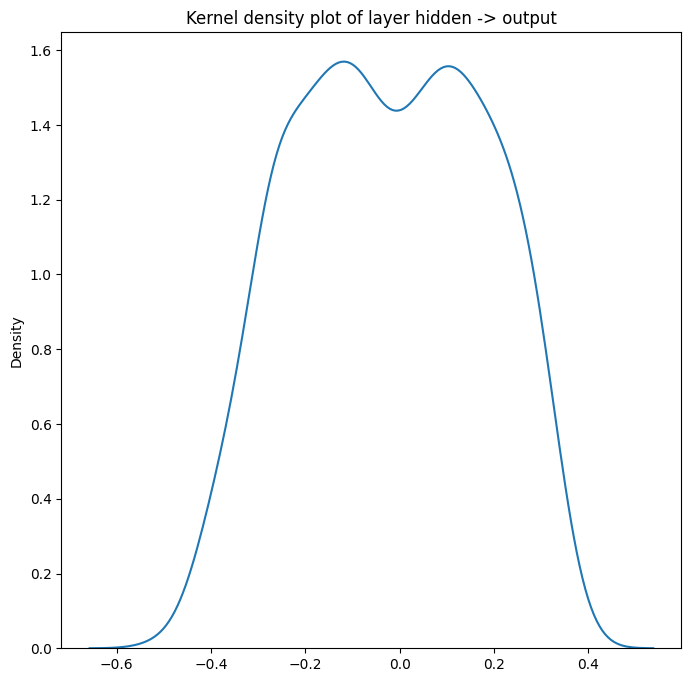

In [20]:
layer_2_means = model.layer_2.weight_mu

utils.visualize_weights(layer_2_means, "layer hidden -> output")
print("Histogram of weights for layer 2")

# Zadanie 4 (1.4 pkt)
Zbadaj wpływ hiperparametrów na działanie modelu:
- parametry w rozkładzie prior (tzn. `sigma_1`, `sigma_2`, `mixing`)
- co się stanie jeśli zastosujemy tylko jeden rozkład normalny jako prior (zamiast mikstury)?
- rozmiar mini-paczki (`batch_size`)
- współczynnik uczenia (`learning_rate`)

### `sigma_1`

Testing 100.0


Epochs: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


Testing 1


Epochs: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


Testing 0.01


Epochs: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


Testing 0.0001


Epochs: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]

Best accuracy


sigma,100.0000,1.0000,0.0100,0.0001
best_accuracy_train,1.000,1.00,1.000,0.96875
best_accuracy_test,0.912,0.75,0.818,0.77000


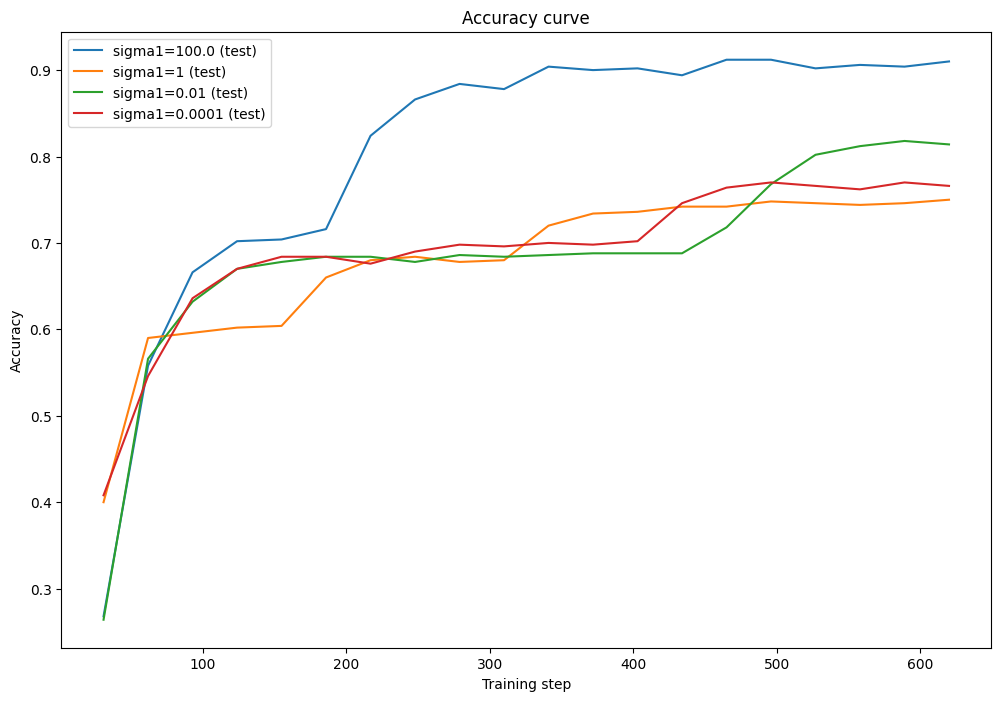

In [26]:
metrics = {}
best_acc = []

for sigma_1 in [1e2, 1, 1e-2, 1e-4]:
    print(f'Testing {sigma_1}')
    model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
        prios_args=dict(sigmas=[sigma_1, 1e-6], mixings=[0.5, 0.5]))
    train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
        loss_function=ELBO(N=10), batch_size=32, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
    metrics[f'sigma1={sigma_1} (test)'] = test_metrics
    best_acc.append(dict(sigma=sigma_1, best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))

utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('sigma').T)

Wyższe wartości `sigma` pierwszego rozkładu, oznaczająca większe rozłożenie rozkładu i mniejszy czubek, prowadziły do lepszych wyników.

### `sigma_2`

Testing 1


Epochs: 100%|██████████| 20/20 [00:43<00:00,  2.15s/it]


Testing 0.01


Epochs: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


Testing 0.0001


Epochs: 100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


Testing 1e-06


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]

Best accuracy


sigma,1.000000,0.010000,0.000100,0.000001
best_accuracy_train,1.000,1.000,1.000,0.96875
best_accuracy_test,0.808,0.842,0.828,0.80000


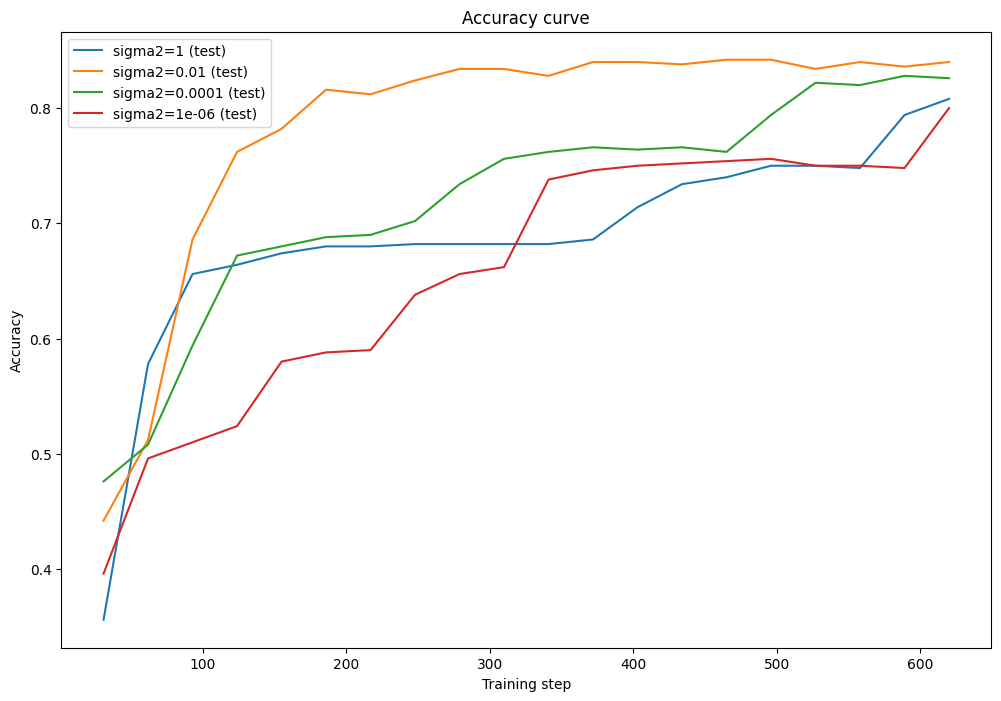

In [28]:
metrics = {}
best_acc = []

for sigma_2 in [1, 1e-2, 1e-4, 1e-6]:
    print(f'Testing {sigma_2}')
    model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
        prios_args=dict(sigmas=[100, sigma_2], mixings=[0.5, 0.5]))
    train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
        loss_function=ELBO(N=10), batch_size=32, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
    metrics[f'sigma2={sigma_2} (test)'] = test_metrics
    best_acc.append(dict(sigma=sigma_2, best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))

utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('sigma').T)

`sigma` drugiego rozkładu najlepsze wyniki dała dla 0.01, czyli wąski czubek i zwężoy rozkład w porównaniu do pierwszego, natomiast nie za wąski (wyszło gorzej np dla 0.001)

### `mixing`

Testing 0.25


Epochs: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


Testing 0.5


Epochs: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Testing 0.75


Epochs: 100%|██████████| 20/20 [00:46<00:00,  2.31s/it]

Best accuracy


mixing,0.25,0.50,0.75
best_accuracy_train,1.000,0.9375,0.96875
best_accuracy_test,0.906,0.6820,0.86600


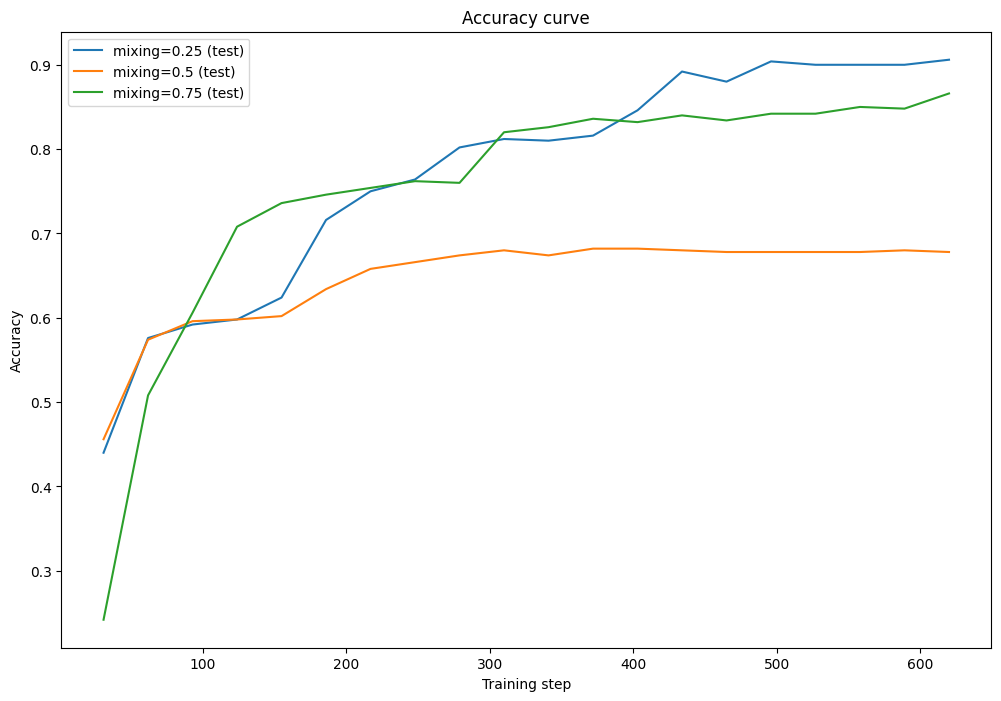

In [29]:
metrics = {}
best_acc = []

for mixing in [0.25, 0.5, 0.75]:
    print(f'Testing {mixing}')
    model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
        prios_args=dict(sigmas=[100, 1e-2], mixings=[mixing, 1 - mixing]))
    train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
        loss_function=ELBO(N=10), batch_size=32, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
    metrics[f'mixing={mixing} (test)'] = test_metrics
    best_acc.append(dict(mixing=mixing, best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))

utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('mixing').T)

Najlepiej było użyć 25% rozkłądu pierwszego (szeroki i płaski) oraz 75% rozkładu drugiego (wąski i szpiczasty)

### `Jeden rozkład normalny zamiast mikstury`

Epochs: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]

Best accuracy


type,mixture,one normal
best_accuracy_train,0.96875,0.96875
best_accuracy_test,0.82600,0.79600


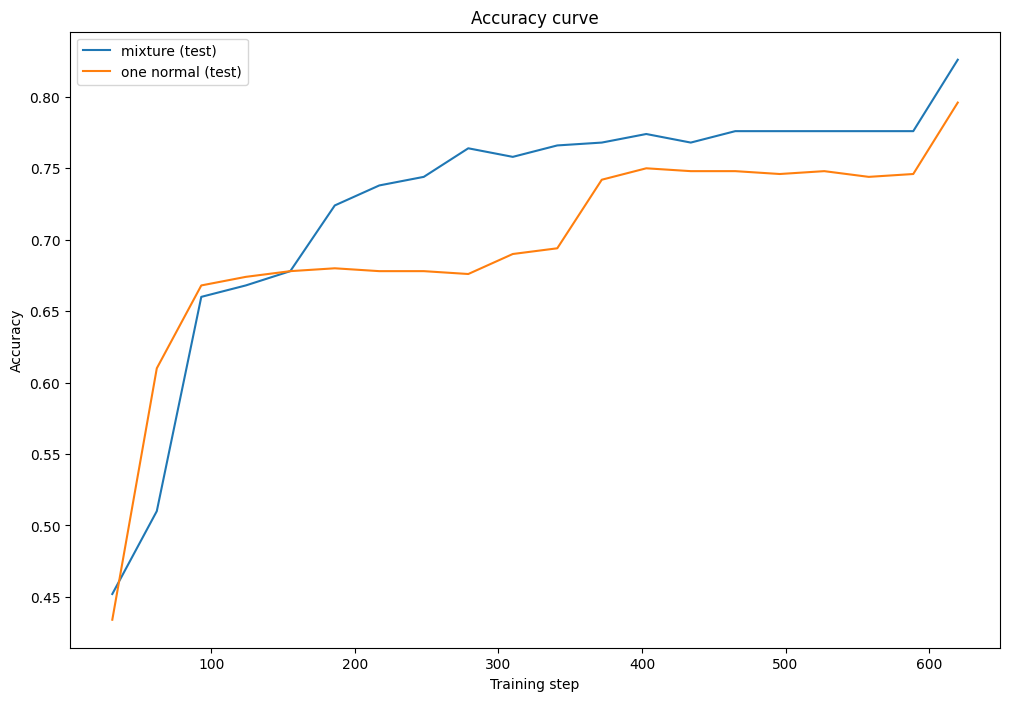

In [30]:
metrics = {}
best_acc = []

model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
    prios_args=dict(sigmas=[100, 1e-2], mixings=[0.25, 0.75]))
train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
    loss_function=ELBO(N=10), batch_size=32, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
metrics[f'mixture (test)'] = test_metrics
best_acc.append(dict(type='mixture', best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))

model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
    prios_args=dict(sigmas=[1], mixings=[1]))
train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
    loss_function=ELBO(N=10), batch_size=32, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
metrics[f'one normal (test)'] = test_metrics
best_acc.append(dict(type='one normal', best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))

utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('type').T)

Wykorzystanie 2 rozkładów zamiast 1 daje lepsze wyniki, chociaż różnica nie jest duża.

### `batch_size`

Testing 8


Epochs: 100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


Testing 16


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


Testing 32


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Testing 64


Epochs: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

Best accuracy


batch_size,8,16,32,64
best_accuracy_train,1.000,1.000,1.00,0.9375
best_accuracy_test,0.916,0.828,0.91,0.8380


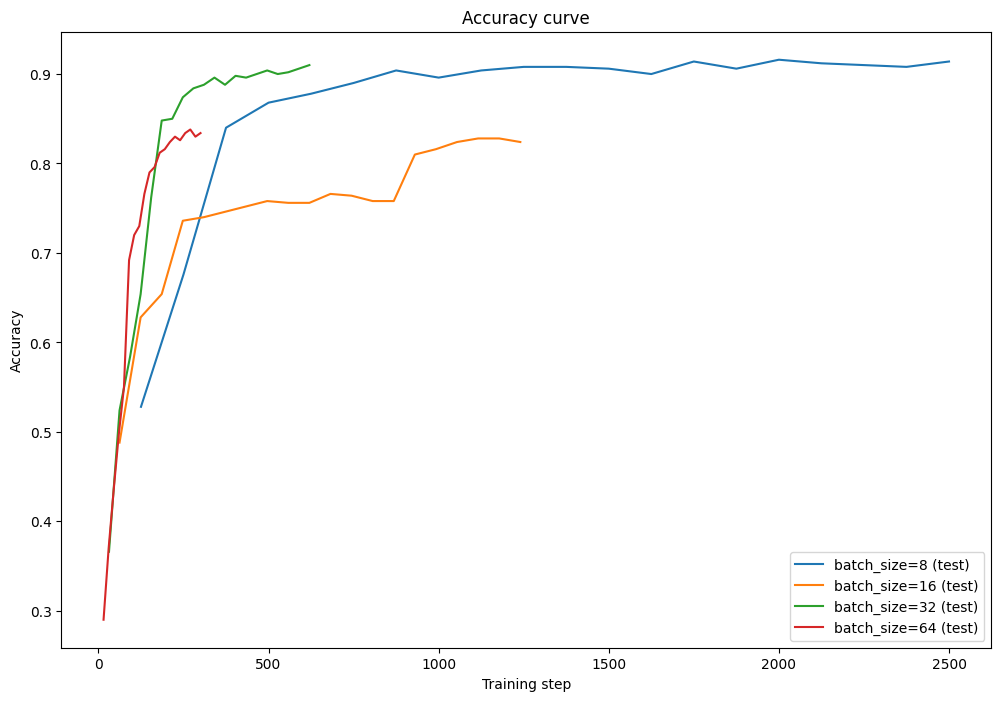

In [10]:
metrics = {}
best_acc = []

for bs in [8, 16, 32, 64]:
    print(f'Testing {bs}') 
    model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
        prios_args=dict(sigmas=[100, 1e-2], mixings=[0.25, 0.75]))
    train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
        loss_function=ELBO(N=10), batch_size=bs, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3))
    metrics[f'batch_size={bs} (test)'] = test_metrics
    best_acc.append(dict(batch_size=bs, best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))
    
utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('batch_size').T)

Im mniejszy `batch_size` tym lepsze wyniki

### `learning_rate`

Testing 0.1


Epochs: 100%|██████████| 20/20 [02:44<00:00,  8.24s/it]


Testing 0.01


Epochs: 100%|██████████| 20/20 [02:57<00:00,  8.87s/it]


Testing 0.001


Epochs: 100%|██████████| 20/20 [02:44<00:00,  8.22s/it]


Testing 0.0001


Epochs: 100%|██████████| 20/20 [03:24<00:00, 10.25s/it]

Best accuracy


learning_rate,0.1000,0.0100,0.0010,0.0001
best_accuracy_train,0.625,1.000,1.000,1.000
best_accuracy_test,0.160,0.806,0.898,0.598


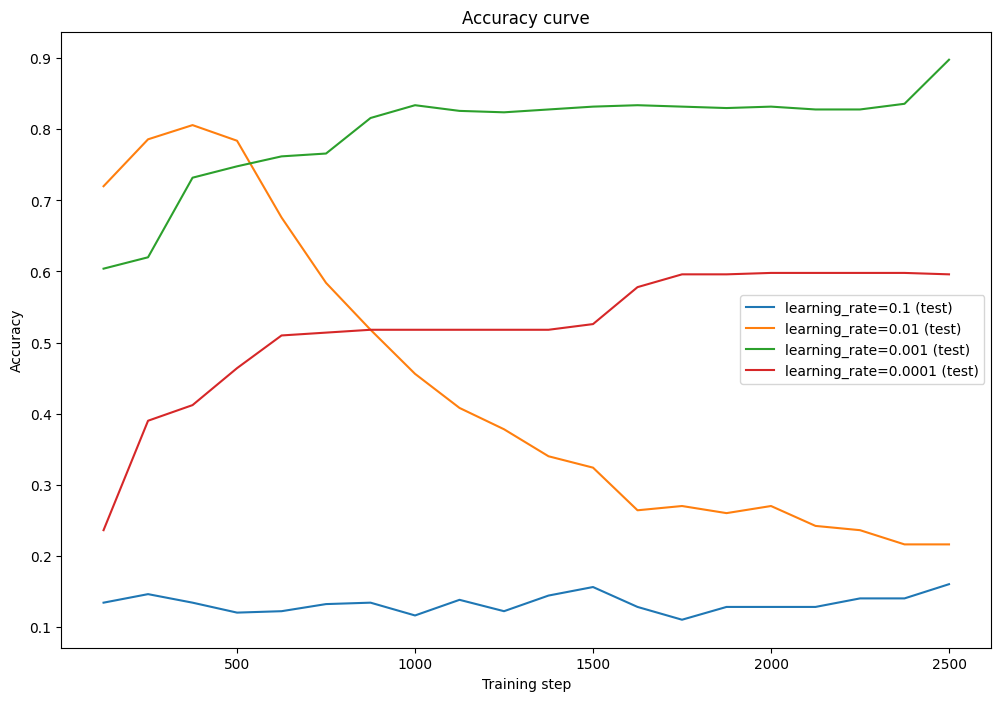

In [11]:
metrics = {}
best_acc = []

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    print(f'Testing {lr}') 
    model = BayesianMLP( num_input_features=28 * 28, num_hidden_features=128, num_output_classes=10,
        prios_args=dict(sigmas=[100, 1e-2], mixings=[0.25, 0.75]))
    train_metrics, test_metrics = utils.fit_elbo(model=model, train_dataset=train_dataset, valid_dataset=test_dataset,
        loss_function=ELBO(N=10), batch_size=8, epochs=20, optimizer=torch.optim.Adam(model.parameters(), lr=lr))
    metrics[f'learning_rate={lr} (test)'] = test_metrics
    best_acc.append(dict(learning_rate=lr, best_accuracy_train=max(train_metrics['acc']), best_accuracy_test=max(test_metrics['acc'])))
    
utils.show_accuracy_curves(metrics)
print("Best accuracy")
display(pd.DataFrame(best_acc).set_index('learning_rate').T)

Domyślny `learing rate` 1e-3 dał najlepsze wyniki.